# 데이터 준비하기

In [56]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow   

# 필요한 라이브러리 가져오기
from PIL import Image
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 가위, 바위, 보 파일 크기 변환

정확도를 상승시키기 위해 5조에서 모인 모든 데이터를 사용하기로 함.(2100장씩 6300장)
모든 데이터를 train, test set 으로 나누어서 사용.

In [57]:


def convertImageSize(name):
    image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rcp_all/"+name
    print("이미지 디렉토리 경로: ", image_dir_path)

    images=glob.glob(image_dir_path + "/*.jpg")  

    img_size = 28
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(img_size,img_size)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")

    print("{} 이미지 resize 완료!".format(name))

classes_train = ['scissor_all','rock_all','paper_all']
for c in classes_train:
    convertImageSize(c)

이미지 디렉토리 경로:  /home/aiffel0042/aiffel/rock_scissor_paper/rcp_all/scissor_all
scissor_all 이미지 resize 완료!
이미지 디렉토리 경로:  /home/aiffel0042/aiffel/rock_scissor_paper/rcp_all/rock_all
rock_all 이미지 resize 완료!
이미지 디렉토리 경로:  /home/aiffel0042/aiffel/rock_scissor_paper/rcp_all/paper_all
paper_all 이미지 resize 완료!


## 데이터 전부 불러오고, train/test 데이터 분리
[데이터 분리 참조](https://rfriend.tistory.com/519)

In [58]:
def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=2100*3   # 데이터는 2100개씩 있음
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor_all/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock_all/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper_all/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("전체(x_whole) 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rcp_all/"
(x_whole, y_whole)=load_data(image_dir_path)

# x_whole_norm = x_whole/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_whole shape: {}".format(x_whole.shape))
print("y_whole shape: {}".format(y_whole.shape))

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_whole,y_whole, test_size=0.2, shuffle=True, random_state=500)
print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화


전체(x_whole) 이미지 개수는 6300 입니다.
x_whole shape: (6300, 28, 28, 3)
y_whole shape: (6300,)
x_train shape: (5040, 28, 28, 3)
x_test shape: (1260, 28, 28, 3)
y_train shape: (5040,)
y_test shape: (1260,)


# 이미지 살펴보기

라벨:  2


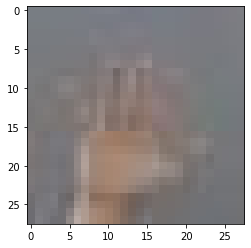

In [59]:
import matplotlib.pyplot as plt
plt.imshow(x_train[601])
print('라벨: ', y_train[601])

# 딥러닝 네트워크 설계하기

In [60]:
n_channel_1=32
n_channel_2=64
n_dense=64
n_train_epoch=20

n_image_channel = 3
n_classes = 3

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,n_image_channel)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
print('Model에 추가된 Layer 개수: ', len(model.layers))


model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_17 (Dense)             (

# 딥러닝 네트워크 학습시키기

In [61]:
# 모델 훈련
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/20
158/158 [==============================] - 0s 1ms/step - loss: 0.7722 - accuracy: 0.6486
Epoch 2/20
158/158 [==============================] - 0s 1ms/step - loss: 0.3651 - accuracy: 0.8540
Epoch 3/20
158/158 [==============================] - 0s 1ms/step - loss: 0.2398 - accuracy: 0.9129
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.9546
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9702
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9813
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0413 - accuracy: 0.9897
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9921
Epoch 9/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9942
Epoch 10/20
158/158 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.9948

# 테스트
테스트 데이터는 이미 만들어져 있음

In [62]:
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (1260, 28, 28, 3)
y_test shape: (1260,)


## loss, accuracy 측정

In [63]:

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=3  #4번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

40/40 - 0s - loss: 0.0233 - accuracy: 0.9968
test_loss: 0.023316219449043274 
test_accuracy: 0.9968253970146179
model.predict() 결과 :  [5.5876913e-05 2.5492906e-07 9.9994385e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


# 더 좋은 네트워크 만들어보기

In [64]:
# 모델 설계
n_channel_1=32
n_channel_2=64
n_dense=256
n_train_epoch=20

n_image_channel = 3
n_classes = 3

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,n_image_channel)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
print('Model에 추가된 Layer 개수: ', len(model.layers))


model.summary()

# 모델 훈련
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 테스트
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=3  #4번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

Model에 추가된 Layer 개수:  7
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               409856    
_________________________________________________________________
dense_19 (Dense)             (